In [1]:
import pickle as pcl
import os
import sys

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d

import astropy.units as u
from astropy.cosmology import Planck13 as cosmo

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
import matplotlib as mpl

from predict import predict
from methods.spectres import spectres
import extinction

R_V = 3.2

Using TensorFlow backend.


In [2]:
mpa = pcl.load(open('data/mpa_df.p','rb'))

mpa_index_arr, wavelength_arr, spec_arr, noise_arr, redshift_arr, M_g, M_r =\
    pcl.load(open('data/spec_pickles_selection.p','rb'))

### Load simulation data

In [3]:
si = predict(fname='data/full_histories_illustris.h5')
se = predict(fname='data/full_histories_eagle.h5')

Load simulation g / r magnitudes

In [4]:
illustris_g_dust = si.load_arr('M_g','Photometry/Dust')
illustris_r_dust = si.load_arr('M_r','Photometry/Dust')

eagle_g_dust = se.load_arr('M_g','Photometry/Dust')
eagle_r_dust = se.load_arr('M_r','Photometry/Dust')

## Simulation motivated colour selection

Resample SDSS to fit simulation g / r distribution

Need to limit simulation results to those with $r$ band apparent magnitude < 17.77 (target magnitude limit, see [here](https://classic.sdss.org/dr7/)), which corresponds to the following absolute magnitude at $z = 0.1$:

In [5]:
lim_mag = 17.77 - (5 * np.log10(cosmo.luminosity_distance(0.1).to(u.pc).value / 10))
lim_mag_e = 17.77 - (5 * np.log10(cosmo.luminosity_distance(se.redshift).to(u.pc).value / 10))
lim_mag_i = 17.77 - (5 * np.log10(cosmo.luminosity_distance(si.redshift).to(u.pc).value / 10))
lim_mag_hi = 17.77 - (5 * np.log10(cosmo.luminosity_distance(0.11).to(u.pc).value / 10))
lim_mag_lo = 17.77 - (5 * np.log10(cosmo.luminosity_distance(0.09).to(u.pc).value / 10))
print('High:', lim_mag_hi, '| Mid:', lim_mag, '| Low:', lim_mag_lo)
print('EAGLE:', lim_mag_e, '| Illustris:', lim_mag_i)

eagle_mask = eagle_r_dust < lim_mag_hi
illustris_mask = illustris_r_dust < lim_mag_hi

pcl.dump([eagle_mask, illustris_mask], open('data/sim_selection_masks.p', 'wb'))

High: -20.835392181678724 | Mid: -20.61410806620575 | Low: -20.370794337182762
EAGLE: -20.63715619167409 | Illustris: -20.600216229392945


Selection

In [6]:
bins = (80,80)
bin_range = [[-24.5,-18.2],[-24.5,-18.2]]

count, xedges, yedges, binnumber = binned_statistic_2d(x=np.hstack([eagle_g_dust[eagle_mask], 
                                                                    illustris_g_dust[illustris_mask]]), 
                                                       y=np.hstack([eagle_r_dust[eagle_mask],
                                                                    illustris_r_dust[illustris_mask]]), 
                                                       values=np.ones(np.sum(eagle_mask)+np.sum(illustris_mask)), 
                                                       statistic='count', bins=bins, 
                                                       range=bin_range, expand_binnumbers=True)

count2, xedges, yedges, binnumber2 = binned_statistic_2d(x=M_g, y=M_r,
                                                         values=np.ones(len(M_g)), 
                                                         statistic='count', bins=bins, 
                                                         range=bin_range, expand_binnumbers=True)

prob = np.array([count[binnumber2[0,i] - 1, binnumber2[1,i] - 1] for i in np.arange(len(M_g))])
prob2 = np.array([count2[binnumber2[0,i] - 1, binnumber2[1,i] - 1] for i in np.arange(len(M_g))])

probabilities = prob / prob2
probabilities[np.isnan(probabilities)] = 0.

indices = np.random.choice(np.arange(len(M_g)), size=10000, replace=False, 
                           p=probabilities / np.nansum(probabilities))

/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Plot distributions in g / r space

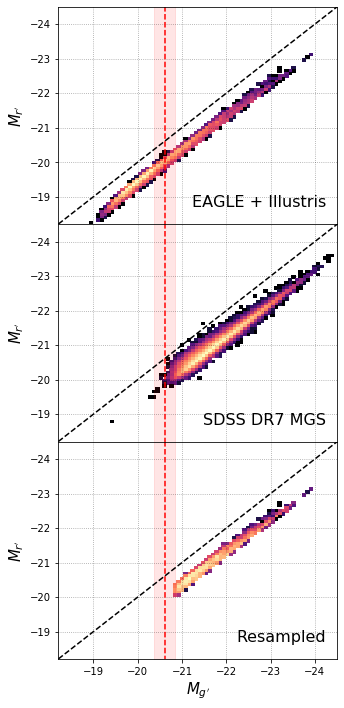

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(5,12))

plt.subplots_adjust(wspace=0, hspace=0)

h = ax1.hist2d(np.hstack([eagle_r_dust, illustris_r_dust]),
               np.hstack([eagle_g_dust, illustris_g_dust]), 
               bins=bins, range=bin_range, cmap='magma', norm=mpl.colors.LogNorm())

# h = ax1.hist2d(eagle_r_dust, eagle_g_dust, bins=bins, range=bin_range, 
#                cmap='magma', norm=mpl.colors.LogNorm())

ax1.text(-24.25, -18.7, 'EAGLE + Illustris', 
         color='black', size=16, horizontalalignment='right')

h = ax2.hist2d(M_r, M_g, bins=bins, range=bin_range, 
               cmap='magma', norm=mpl.colors.LogNorm())

ax2.text(-24.25, -18.7, 'SDSS DR7 MGS', color='black', size=16, horizontalalignment='right')

h = ax3.hist2d(M_r[indices], M_g[indices], bins=bins, range=bin_range, 
               cmap='magma', norm=mpl.colors.LogNorm())

ax3.text(-24.25, -18.7, 'Resampled', color='black', size=16, horizontalalignment='right')

for ax in [ax1,ax2,ax3]:
    ax.plot([-25,-17], [-25,-17], linestyle='dashed', color='black')
    
    ax.set_xlabel('$M_{g\'}$', size=15)
    ax.set_ylabel('$M_{r\'}$', size=15)
    
    ax.vlines(lim_mag, -17, -25, color='red', linestyle='dashed')
    
    ax.grid(color='black', ls='dotted', alpha=0.4)
    
    ax.fill_between([lim_mag_lo,lim_mag_hi],-17,-25, color='red', alpha=0.1)
    
    ax.set_xlim(-18.2, -24.5)
    ax.set_ylim(-18.2, -24.5)

    
# fig.savefig('plots/sdss_g_r_selection.png', dpi=200, bbox_inches='tight', pad_inches=0)

## $M_{*}$ - magnitude distribution

In [8]:
mpa_mass = mpa.loc[np.hstack(mpa_index_arr)]['mpa_mass']
vespa_mass = np.array(np.log10(mpa.loc[np.hstack(mpa_index_arr)]['M_stellar']))

illustris_mstar = si.load_arr('Stellar Mass 30kpc','Subhalos')
eagle_mstar = np.log10(se.load_arr('Stellar Mass 30kpc','Subhalos'))

Mag - $M_{*}$

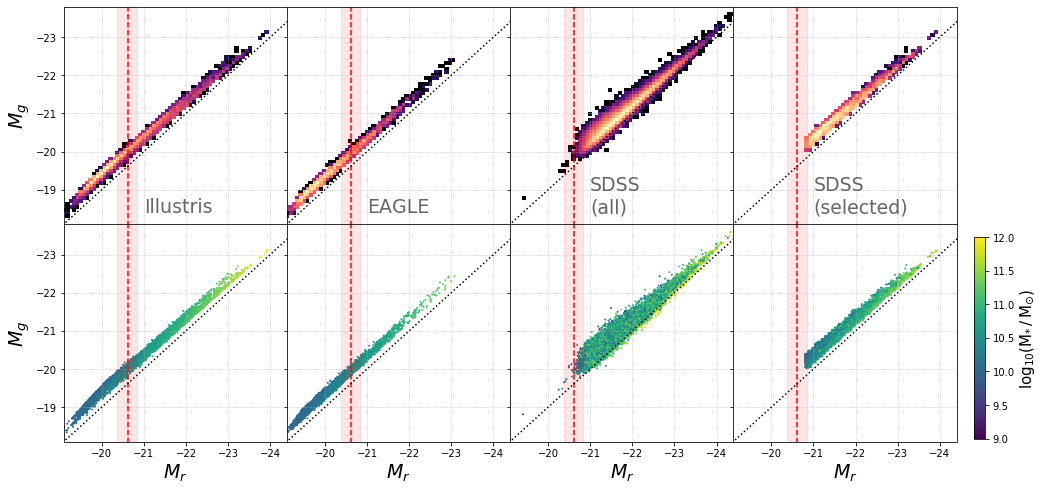

In [10]:
fig, ((ax1,ax2,ax3,ax4),(ax1b,ax2b,ax3b,ax4b)) = plt.subplots(2,4, figsize=(16,8))

plt.subplots_adjust(wspace=0, hspace=0)

s = ax1b.scatter(illustris_r_dust, illustris_g_dust, s=1, alpha=1, c=illustris_mstar, vmin=9, vmax=12)
ax2b.scatter(eagle_r_dust, eagle_g_dust, s=1, alpha=1, c=eagle_mstar, vmin=9, vmax=12)

mask = (vespa_mass > 9.0)
ax3b.scatter(M_r[mask], M_g[mask], s=1, alpha=1, c=vespa_mass[mask], vmin=9, vmax=12)
# ax3b.scatter(M_r, M_g, s=1, alpha=1, c=vespa_mass, vmin=9, vmax=12)

ax4b.scatter(M_r[indices], M_g[indices], s=1, alpha=1, c=vespa_mass[indices], vmin=9, vmax=12)


## Hist2D ##
bins = (80,80)
bin_range = [[-24.5,-18.2],[-24.5,-18.2]]

h = ax2.hist2d(eagle_r_dust, eagle_g_dust, bins=bins, range=bin_range, 
               cmap='magma', norm=mpl.colors.LogNorm())

h = ax1.hist2d(illustris_r_dust, illustris_g_dust, bins=bins, range=bin_range, 
               cmap='magma', norm=mpl.colors.LogNorm())

# ax1b.text(-24.25, -18.7, 'EAGLE + Illustris', 
#          color='black', size=16, horizontalalignment='right')

# h = ax2.hist2d(R_mag_temp, G_mag_temp, bins=bins, range=bin_range, cmap='magma')
h = ax3.hist2d(M_r, M_g, bins=bins, range=bin_range, 
               cmap='magma', norm=mpl.colors.LogNorm())

# ax2b.text(-24.25, -18.7, 'SDSS DR7 MGS', color='black', size=16, horizontalalignment='right')

# h = ax3.hist2d(R_mag_temp[indices], G_mag_temp[indices], bins=bins, range=bin_range, cmap='magma')
h = ax4.hist2d(M_r[indices], M_g[indices], bins=bins, range=bin_range, 
               cmap='magma', norm=mpl.colors.LogNorm())

cax = fig.add_axes([0.915, 0.13, 0.01, 0.35])
plt.colorbar(s, cax=cax).set_label(label='$\mathrm{log_{10}(M_{*} \,/\, M_{\odot})}$', size=15)



for ax in [ax1,ax2,ax3,ax4,ax1b,ax2b,ax3b,ax4b]:
    ax.set_xlim(-19.1,-24.4)
    ax.set_ylim(-18.1,-23.8)
    ax.vlines(lim_mag, -17, -25, color='red', linestyle='dashed')
    ax.fill_between([lim_mag_lo, lim_mag_hi],-17,-25,color='red', alpha=0.1)
    ax.plot([-19,-25],[-18,-24],color='black', linestyle='dotted')
    ax.grid(linestyle='dotted', alpha=0.8)


textsize=19
for ax in [ax1,ax1b]:
    ax.set_ylabel('$M_{g}$', size=textsize);
    
for ax in [ax1b,ax2b,ax3b,ax4b]:
    ax.set_xlabel('$M_{r}$', size=textsize)
    
for ax in [ax2,ax3,ax4,ax2b,ax3b,ax4b]:
    ax.set_yticklabels([])
    
ax1.text(-21, -18.4, 'Illustris', alpha=0.6, size=textsize)
ax2.text(-21, -18.4, 'EAGLE', alpha=0.6, size=textsize)
ax3.text(-21, -18.4, 'SDSS\n(all)', alpha=0.6, size=textsize)
ax4.text(-21, -18.4, 'SDSS\n(selected)', alpha=0.6, size=textsize)

# fig.savefig('plots/sdss_g_r_selection_mass.png', dpi=200, bbox_inches='tight', pad_inches=0)

# Convert & Save

Convert spectra from observer frame flux to intrinsic luminosity, resample on uniform wavelength grid, remove galactic extinction, and save to `spectacle` instance.

In [45]:
def spectra_unit_conversion(f, z):
    out = f * 1e-17       # erg s^-1 cm^-2 AA^-1
    out = out * 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2   # erg s^-1 AA^-1
    out /= (1+z)
    out /= 3.826e33   # Lsol AA^-1
    return out

new_wl = np.loadtxt('data/wavelength_grid.txt')

spectrum = np.zeros((len(indices), len(new_wl)))
spectrum_error = np.zeros((len(indices), len(new_wl)))
interpolated = np.zeros(len(indices), dtype='bool')

for j,i in enumerate(indices):
    
    if j%200 == 0: print("%.2f%%"%(float(j)*100/len(indices)))
    
    s = spec_arr[i].copy()
    s_error = noise_arr[i].copy()
    wavelength = wavelength_arr[i].copy()
    z = redshift_arr[i]
    
    A_V = R_V * mpa.loc[mpa_index_arr[i]]['E_BV_SFD']
    e = extinction.odonnell94(wavelength, A_V, R_V)
#     e = extinction.calzetti00(wavelength, A_V, R_V)
    trans = 10**(0.4 * e)
    
    s *= trans
    s *= mpa.loc[mpa_index_arr[i]]['spectra_correction']#.values
    
    s = spectra_unit_conversion(s, z)
    s_error = spectra_unit_conversion(s_error, z)
    
    wavelength /= (1+z)
    
    spectrum[j,:], spectrum_error[j,:] = spectres(spec_wavs=wavelength, spec_fluxes=s,
                                                  resampling=new_wl, spec_errs=s_error)


0.00%
2.00%
4.00%
6.00%
8.00%
10.00%
12.00%
14.00%
16.00%
18.00%
20.00%
22.00%
24.00%
26.00%
28.00%
30.00%
32.00%
34.00%
36.00%
38.00%
40.00%
42.00%
44.00%
46.00%
48.00%
50.00%
52.00%
54.00%
56.00%
58.00%
60.00%
62.00%
64.00%
66.00%
68.00%
70.00%
72.00%
74.00%
76.00%
78.00%
80.00%
82.00%
84.00%
86.00%
88.00%
90.00%
92.00%
94.00%
96.00%
98.00%


plot mean spectra

(3572.0000000000005, 8173.000000000001)

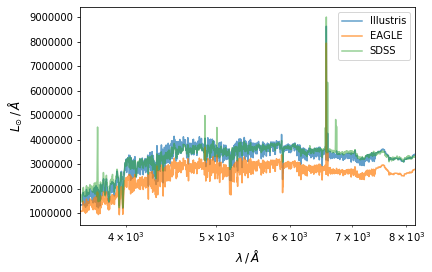

In [46]:
illustris_spec, wl = si.load_spectra('Dust')
illustris_spec = illustris_spec[illustris_mask]
eagle_spec, wl = se.load_spectra('Dust')
eagle_spec = eagle_spec[eagle_mask]

fig = plt.figure()
    
plt.semilogx(wl, np.median(illustris_spec, axis=0), label='Illustris', alpha=0.7)
plt.semilogx(wl, np.median(eagle_spec, axis=0), label='EAGLE', alpha=0.7)

plt.semilogx(new_wl, np.median(spectrum, axis=0), label='SDSS', alpha=0.5)

plt.ylabel('$L_{\odot} \,/\, \AA$', size=12)
plt.xlabel('$\lambda \,/\, \AA$', size=12)
plt.legend()

plt.xlim(new_wl.min(),new_wl.max())
# plt.ylim(1e6,5e6)

# fig.savefig('plots/median_spectra_%s.png'%name, dpi=250, bbox_inches='tight')

Find each galaxies SFH

In [49]:
vespa = pcl.load(open('data/vespa_df.p','rb'))

In [53]:
vespa_group = vespa.groupby('indexP')

histories = np.array([np.array(vespa_group.get_group(k).sort_values(by='binID').reset_index()[['sfr']]).squeeze()\
     for k in mpa.loc[np.array(mpa_index_arr)[indices]]['indexP']])

# apply mass correction
# histories = np.array([hist * corr for hist, corr in zip(histories, 
#         np.array(mpa.loc[np.array(mpa_index_arr)[indices][:,0]]['mass_correction']))])

histories.shape

(10000, 16)

Assign spectra & histories to `predict` instance

In [54]:
tacle = predict(fname='data/vespa_histories.h5', redshift = 0.1)

In [56]:
mpa_temp = mpa.loc[np.array(mpa_index_arr)[indices]].reset_index()

# save wavelength and spectra to dataset
tacle.save_arr(name='ID', group='Subhalos', arr=np.arange(len(mpa_temp)))

tacle.save_spectra('SDSS', spectrum, new_wl, units=str('Lsol / AA'))
tacle.save_spectra('SDSS error', spectrum_error, new_wl, units=str('Lsol / AA'))

tacle.save_arr(name='g',group='Magnitudes',arr=M_g[indices])
tacle.save_arr(name='r',group='Magnitudes',arr=M_r[indices])

tacle.save_arr(name='vespa',group='SFH',arr=histories)

## Subhalos properties
tacle.save_arr(name='mpa_mass',group='Subhalos',arr=mpa_temp['mpa_mass'])
tacle.save_arr(name='mpa_mass_total',group='Subhalos',arr=mpa_temp['mpa_mass_total'])

tacle.save_arr(name='vespa_mass',group='Subhalos',arr=mpa_temp['M_stellar'])
tacle.save_arr(name='vespa_error',group='Subhalos',arr=mpa_temp['M_stellar_error'])
tacle.save_arr(name='vespa_mass_correction',group='Subhalos',arr=mpa_temp['mass_correction'])
tacle.save_arr(name='sn_median',group='Subhalos',arr=mpa_temp['sn_median'])
tacle.save_arr(name='redshift',group='Subhalos',arr=mpa_temp['redshift'])

In [57]:
binid = pd.read_csv('data/VESPA/binId.csv')

bins = binid[binid.widthBin == 1]
binLimits = np.append(bins['ageStart'], np.array(bins['ageEnd'])[-1])
binWidths = binLimits[1:] - binLimits[:-1]
bins = binLimits[1:] - binWidths
custom = {'binLimits': binLimits, 'bins': bins, 'binWidths': binWidths}

bins, binLimits, binWidths = tacle.init_bins(name='vespa_bins', custom=custom, verbose=True)

tacle.training_mask()

Saving bin info to file...
